$\huge{\textbf{MIST Isochrones Only Notebook}
}
$

In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [35]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

import pandas as pd #needed for readmist
def readmist(file):
    with open(file) as f:
        #lines = f.readlines()
        df = pd.read_csv(file,comment='#',names = ['EEP','log10_isochrone_age_yr','initial_mass',\
                                                   'star_mass','log_Teff','log_g','log_L','FeH_init',\
                                                   'FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R',\
                                                   'Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp',\
                                                   'Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V',\
                                                   'Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev',\
                                                   'Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW',\
                                                   'TESS','phase'],sep='\s+')
        table_out = Table.from_pandas(df)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [36]:
files = glob.glob('/Users/joshpovick/desktop/research/Magellanic_Ages/MIST/*.iso.cmd')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1]+splt[2])

for j in range(len(files)):
    tab = readmist(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)

In [75]:
#Read in all MIST file
mist = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmist = Table.from_pandas(mist)
#tmist.show_in_browser(jsviewer=True)
rgb = np.where((tmist['EEP']>=495)&(tmist['EEP']<=605)&(tmist['log_Teff']<=3.75))
trgb = tmist[rgb]

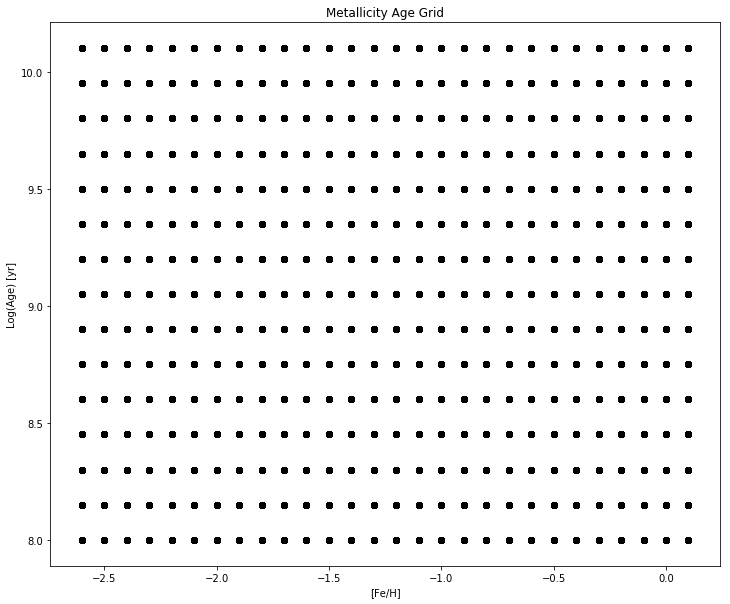

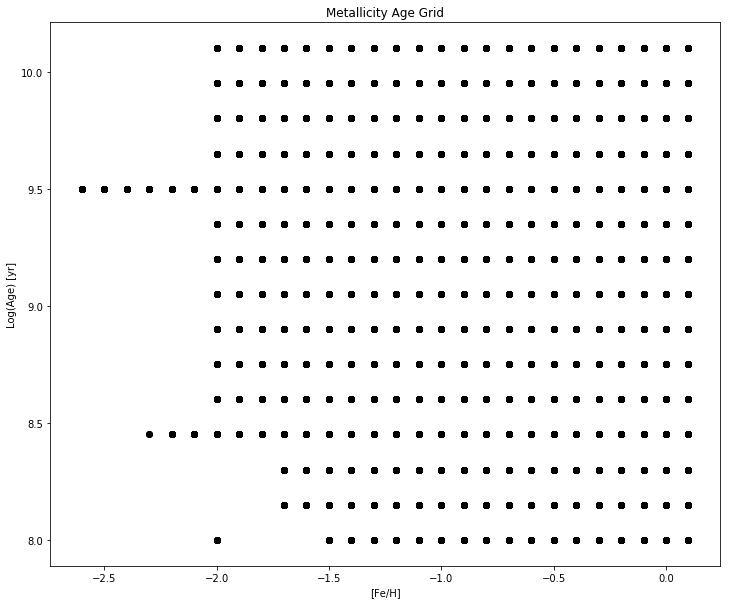

In [39]:
#Metallicity Age
'''When making rgb cut the grid becomes patchy'''
plt.figure(figsize=[12,10])
plt.scatter(tmist['FeH_init'],tmist['log10_isochrone_age_yr'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('MISTgrid.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(trgb['FeH_init'],trgb['log10_isochrone_age_yr'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('MISTrgbgrid.pdf',bbox_inches='tight')
plt.show()

In [34]:
list(set(tmist['log10_isochrone_age_yr']))

[8.0,
 8.15,
 8.449999999999998,
 8.599999999999998,
 8.3,
 8.75,
 8.9,
 9.05,
 9.2,
 9.35,
 9.5,
 9.65,
 9.8,
 9.95,
 10.1]

In [77]:
#######################################
### Check EEP to find bottom of RGB ###
#######################################

'''Determined that bottom is EEP of 495'''
'''See above picking out RGB when importing data'''

# isotest = np.where((tmist['FeH_init']==-1.0)&(tmist['log10_isochrone_age_yr']==9.35))

# plt.figure(figsize=[10,10])
# plt.scatter(tmist[isotest]['log_Teff'],tmist[isotest]['log_g'],c=tmist[isotest]['FeH_init'],cmap='jet',alpha=0.1)
# plt.scatter(tmist[isotest]['log_Teff'][283],tmist[isotest]['log_g'][283],c='k',marker='+',s=500)
# plt.xlim(3.5,4.0)
# plt.ylim(0,4)
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# # plt.colorbar()
# plt.xlabel(r'Log(T) [K]')
# plt.ylabel(r'Log(g)')
# plt.title(r'Color as [Fe/H]')
# plt.show()

# print(tmist[isotest]['EEP'][283])

'See above picking out RGB when importing data'

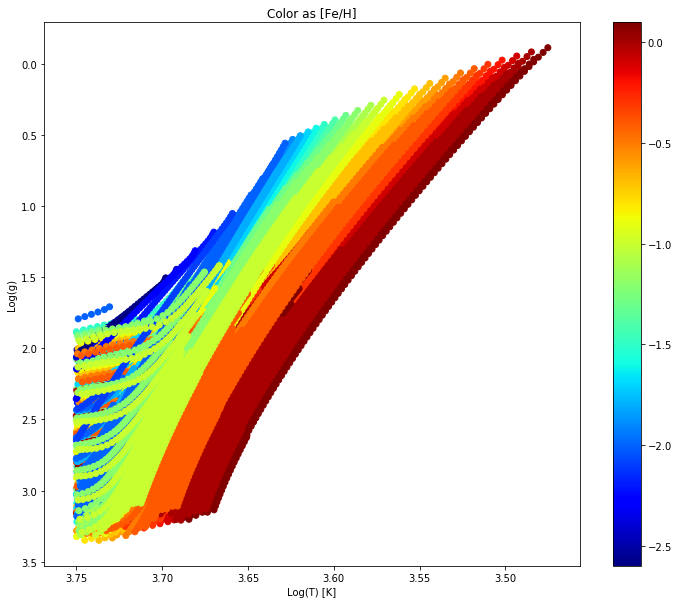

In [76]:
##################
### HR diagram ###
##################

plt.figure(figsize=[12,10])
plt.scatter(trgb['log_Teff'],trgb['log_g'],c=trgb['FeH_init'],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()


In [79]:
##############################
### Import statsmodels.api ###
##############################

import statsmodels.api as sm 

####################
### Prepare Data ###
####################

'''parameters: logTeff, Hmag, [FE/H], logg'''\

logage = np.array(trgb['log10_isochrone_age_yr'].data)

J = np.array(trgb['2MASS_H'].data)
Ks = np.array(trgb['2MASS_Ks'].data)

logteff = np.array(trgb['log_Teff'].data)
H = np.array(trgb['2MASS_H'].data)
feh = np.array(trgb['FeH_init'])
logg = np.array(trgb['log_g'].data)

Using PARSEC Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.503e+06
Date:                Mon, 08 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:07:36   Log-Likelihood:                 69693.
No. Observations:               26714   AIC:                        -1.394e+05
Df Residuals:                   26702   BIC:                        -1.393e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        350.6781      3.894 

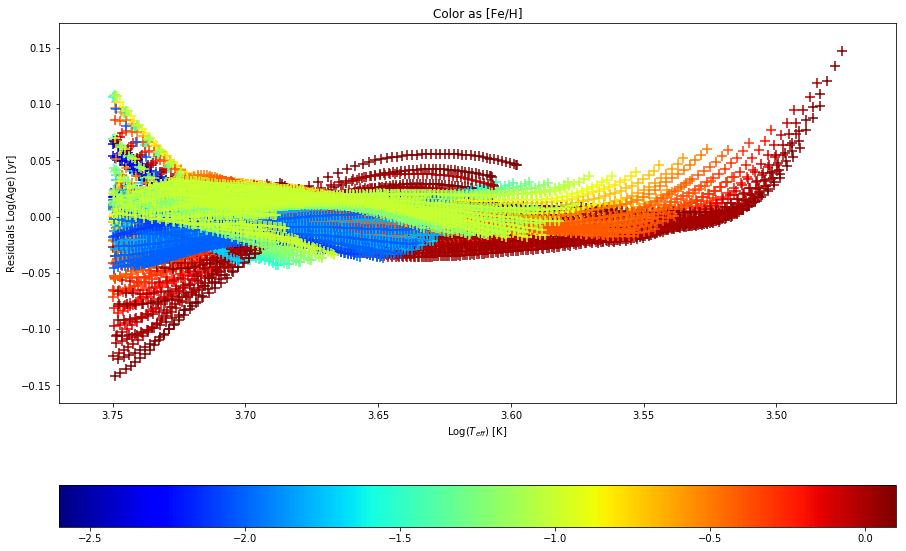

0.010293491327360016
 
 
Using BaSTI Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.653e+06
Date:                Mon, 08 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:07:37   Log-Likelihood:                 72699.
No. Observations:               26714   AIC:                        -1.454e+05
Df Residuals:                   26700   BIC:                        -1.453e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

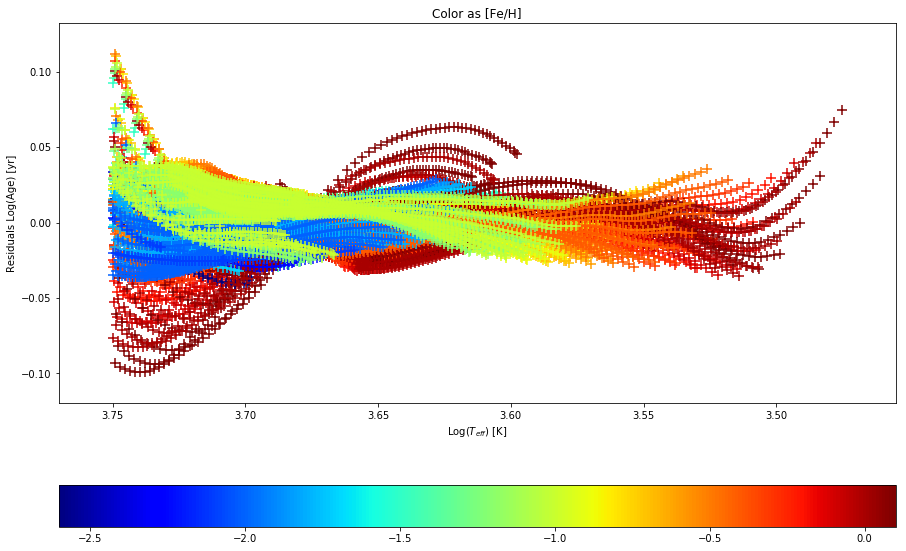

0.008923681677172723


In [87]:
################################
### Fit PARSEC model to MIST ###
################################

print('Using PARSEC Model')

pmodl = np.array([logteff,Ks,feh,logg,np.multiply(logteff,Ks),np.multiply(logteff,feh),\
                   np.multiply(logteff,logg),np.multiply(Ks,logg),\
                   logteff**2,Ks**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.colorbar(orientation='horizontal')
plt.gca().invert_xaxis()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

print(mad(residual))

###############################
### Fit BaSTI model to MIST ###
###############################

print(' ')
print(' ')
print('Using BaSTI Model')

pmodl = np.array([logteff,Ks,feh,logg,np.multiply(logteff,Ks),np.multiply(logteff,feh),\
                  np.multiply(logteff,logg),np.multiply(Ks,logg),np.multiply(logteff**2,feh),\
                  np.multiply(logteff**2,Ks),logteff**2,Ks**2,logg**2]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

print(mad(residual))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.423e+06
Date:                Mon, 08 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:16:43   Log-Likelihood:                 74610.
No. Observations:               26714   AIC:                        -1.492e+05
Df Residuals:                   26704   BIC:                        -1.491e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.0889      0.575    -67.974      0.0

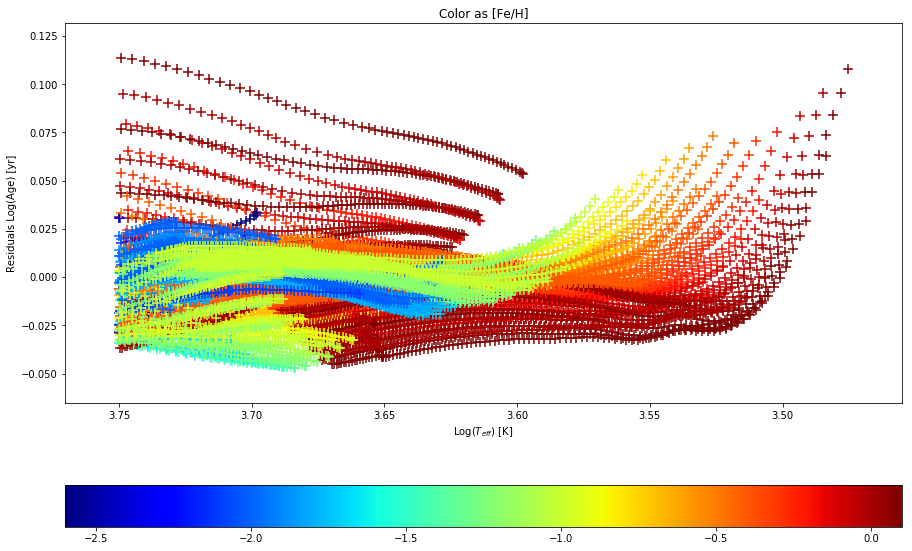

0.007027127025410529


In [117]:
############################
### Testing Other Models ###
############################

pmodl = np.array([logteff,Ks,feh,logg,logteff**2,Ks**2,feh**2,logg**2,np.multiply(Ks,logg)]).T

pmodl = sm.add_constant(pmodl)
model = sm.OLS(logage, pmodl).fit()
predictions = model.predict(pmodl) 
residual = predictions - logage
print_model = model.summary()
print(print_model)
print(model.params)

plt.figure(figsize=[15,10])
plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

print(mad(residual))